# Prediction

In [1]:
from config import config
config = config.Configuration()

In [2]:
%run "patch_creation_pred.py" # 2630DB_2018

45409 110556


In [2]:
%run "patch_creation_pred.py" # 2629BD_2018

108224 107798


In [2]:
# run previous notebooks if necessary
if not "run_prev_notebooks" in locals(): # use case: this notebook
    run_prev_notebooks = False
    %run "1_data_preparation.ipynb"


KeyboardInterrupt



KeyboardInterrupt: 

### Model

In [2]:
from core.losses import tversky, accuracy, dice_coef, dice_loss, specificity, sensitivity
from core.optimizers import adaDelta
OPTIMIZER = adaDelta
LOSS = tversky

In [3]:
import keras
from keras.models import load_model
# check if model_path is already defined. This is the case when you run the pipeline and not this notebook alone
if not "model_path" in locals(): model_path = config.filepath_model
model = load_model(model_path, custom_objects={'tversky': LOSS, 
                                               'dice_coef': dice_coef, 
                                               'dice_loss': dice_loss, 
                                               'accuracy': accuracy , 
                                               'specificity': specificity, 
                                               'sensitivity': sensitivity}, 
                                               compile=False)

2022-04-11 07:45:27.858440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-11 07:45:27.858474: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-11 07:45:27.859094: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [4]:
def inspect_arr(arr):
    print("-")
    print(f"Mean: {np.mean(arr)}")
    print(f"Avg : {np.average(arr)}")
    print(f"Min : {np.min(arr)}")
    print(f"Max : {np.max(arr)}")
    print(f"Shape: {np.array(arr).shape}")

### Test Prediction

In [5]:
%%time
import numpy as np
from sklearn.metrics import mean_squared_error
# predict the target on test data 
pred_test_p = model.predict(X_test) # confidence for class 0
print("Test prediction completed")

Test prediction completed
CPU times: user 42min 10s, sys: 3min 38s, total: 45min 49s
Wall time: 8min 45s


In [6]:
pred_test = (pred_test_p <= 0.97) * pred_test_p
# Root Mean Squared Error on train and test date
flattened_test = np.reshape(y_test,    np.prod(y_test.shape))
flattened_pred = np.reshape(pred_test, np.prod(pred_test.shape))
print('RMSE on test data: ', mean_squared_error(flattened_test, flattened_pred))

# np.average(pred_test_p): 0.14

RMSE on test data:  0.046950677446455216


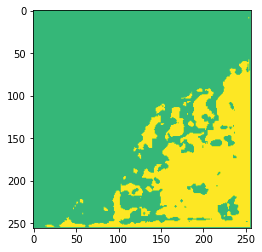

In [10]:
plt.imshow(scale_up_color_val(pred_test_p[33]))
plt.show()

### Functions

In [12]:
def img_size_by_patches(n=429):
    # n patches need an image width of the result:
    return n * config.size - (n-1) * config.overlap
img_size_by_patches(n=483)

108224

In [19]:
from osgeo import gdal
def num_of_patches_in_row(filepath):
    dataset = gdal.Open(config.path_satellite + filename)
    size_x, size_y = (dataset.RasterXSize, dataset.RasterYSize)
    print(f"Size: {size_x} x {size_y}")
    print(f"#Patches in Row: {img_num_by_patch_size(size_x)}")
    del dataset, size_x, size_y

In [13]:
def img_num_by_patch_size(size):
    # how many patches are created with an image width of size
    # works only with size of 256 and overlap of 32
    # 108224 = n * config.size - (n-1) * config.overlap 
    # 7n = 108224 / 32 + 1 
    # n = 108224/224 + 1/7
    return round((size/224) + (1/7))
img_num_by_patch_size(108224)

483

In [42]:
def scale_up_color_val(array):
    return [(num*255).astype(np.uint8) for num in array]

In [8]:
from numpy import ndarray
def show_rounded(idx):
    rounded = [ndarray.round(num, 0) for num in pred_test]
    show_rasterio(pred_test[idx])

In [16]:
from rasterio.plot import show as show_rasterio
from patch_creation import show
def show_img(idx):
    print(idx)
    print("Original")
    show(scale_up_color_val(X_test)[idx], scale_up_color_val(y_test)[idx])
    print("Prediction")
    # print("Rasterio")
    # show_rasterio(pred_test[idx])
    # print("Matplotlib")
    plt.imshow(scale_up_color_val(pred_test[idx]))
    plt.show()
    plt.imshow(scale_up_color_val(pred_test_p[idx]))
    plt.show()

In [17]:
from patch_creation import show
def scale_up_color_val(array):
    return [(num*255).astype(np.uint8) for num in array]

def show_pred(X, y, idx):
    print(idx)
    show(scale_up_color_val(X)[idx], scale_up_color_val(y)[idx])

In [12]:
inspect_arr(pred_test_p)
inspect_arr(pred_test)

-
Mean: 0.9968584775924683
Avg: 0.9968584775924683
Min: 0.8394709825515747
Max: 1.0
-
Mean: 0.033482979983091354
Avg: 0.033482979983091354
Min: 0.0
Max: 0.9700000286102295


In [13]:
import os.path
for filename in config.pred_imgs:
    filepath = config.path_satellite + filename
    print(filepath, os.path.isfile(filepath))

/Users/leori/Desktop/BA/1_Data/2_satellite/2629BD_2018.tif True


In [5]:
import os.path
filename = config.pred_imgs[0]
os.path.isfile(config.path_satellite + filename), config.path_satellite + filename

(True, '/home/jovyan/work/satellite_data/2629BD_2018.tif')

In [6]:
%%time
import os.path
filepath_pred_patches = f"{config.path_patches}pred_patches_{config.pred_imgs[0][:-4]}.npy"
# check if satellite image exists and the patches have not been generated previously
if os.path.isfile(config.path_satellite + config.pred_imgs[0]) and not os.path.isfile(filepath_pred_patches):
    %run "patch_creation_pred.py"
    print("Patches Created")

CPU times: user 1.92 ms, sys: 0 ns, total: 1.92 ms
Wall time: 10.1 ms


In [11]:
%%time
import numpy as np
filename = config.pred_imgs[0]
X_pred = np.load(filepath_pred_patches)
print(X_pred.shape)
#pred_sat = model.predict(X_pred) # confidence for class 0?

(232323, 256, 256, 3)
CPU times: user 0 ns, sys: 3min 28s, total: 3min 28s
Wall time: 10min 13s


In [15]:
inspect_arr(X_pred)

-
Mean: 120.32049118249998
Avg: 120.32049118249998
Min: 0
Max: 255
Shape: (232323, 256, 256, 3)


In [ ]:
y_pred = model.predict(X_pred)
filepath_pred_y = f"{config.path_patches}y_pred_patches_{filename[:-4]}.npy"
np.save(filepath_pred_y, y_pred)

In [ ]:
idx = 1000
y_pred = model.predict(np.expand_dims(X_pred[idx], 0))

show(scale_up_color_val(X_pred)[idx], scale_up_color_val(y_pred))

In [7]:
filepath_pred_patches

'/home/jovyan/work/saved_data/south_africa_tree_stock/3_patches/pred_patches_2629BD_2018.npy'

In [20]:
num_of_patches_in_row(filepath_pred_patches)

Size: 108224 x 107798
#Patches in Row: 483


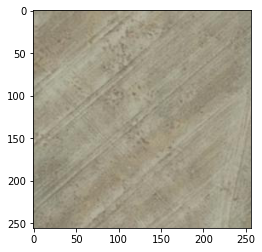

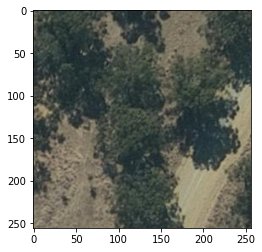

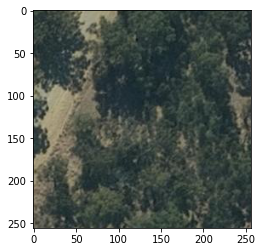

In [62]:
pred_patches_idx = [469, 919, 920]
for x in pred_patches_idx:
    plt.imshow(X_pred[x])
    plt.show()

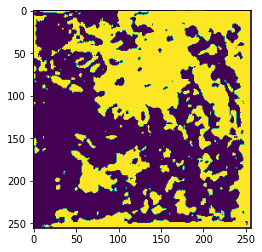

In [60]:
plt.imshow(np.reshape(scale_up_color_val(pred_sat), (256, 256, 1)))
# plt.imshow(scale_up_color_val(pred_sat))
plt.show()

In [13]:
filepath_pred_y = f"{config.path_patches}y_pred_patches_{filename[:-4]}.npy"
filepath_pred_y

'/home/jovyan/work/saved_data/south_africa_tree_stock/3_patches/y_pred_patches_2629BD_2018.npy'

In [8]:
y_pred = model.predict(X_pred)
filepath_pred_y = f"{config.path_patches}y_pred_patches_{filename[:-4]}.npy"
np.save(filepath_pred_y, y_pred)

NameError: name 'X_pred' is not defined

In [115]:
y_pred = np.load(filepath_pred_y)

In [ ]:
# X_pred = scale_up_color_val(X_pred) # scaling distorts the image
y_pred = np.reshape(scale_up_color_val(y_pred), y_pred.shape[:-1])
y_pred = np.reshape(y_pred, y_pred.shape[:-1])

469


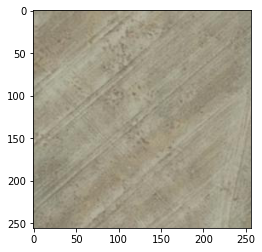

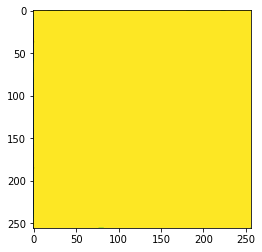

919


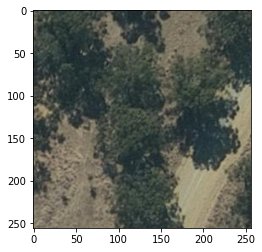

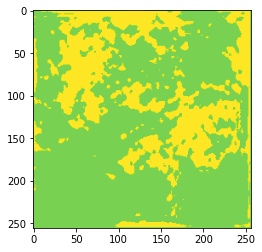

920


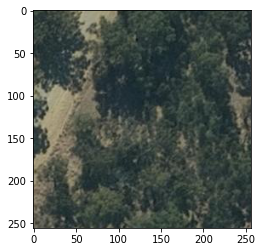

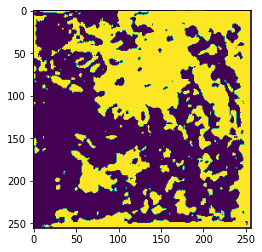

In [141]:
for idx in  pred_patches_idx:
    print(idx)
    # inspect_arr(X_pred[idx])
    plt.imshow(X_pred[idx])
    plt.show()
    # inspect_arr(scale_up_color_val(y_pred[idx]))
    plt.imshow(scale_up_color_val(y_pred[idx]))
    plt.show()

469


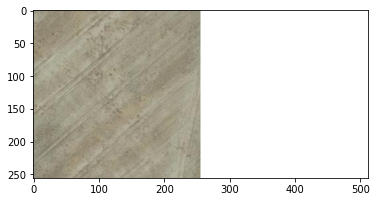

919


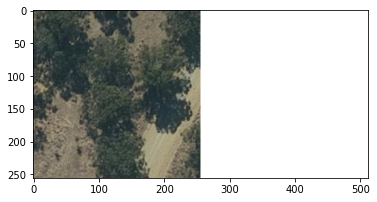

920


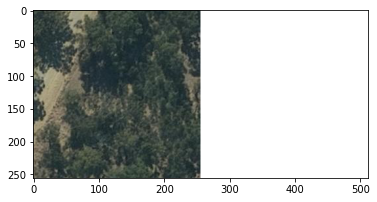

In [149]:
for idx in  pred_patches_idx:
    print(idx)
    show(scale_up_color_val(X_pred[idx]), np.array(scale_up_color_val(y_pred[idx])))

In [ ]:
# inspect_arr(X_pred), inspect_arr(y_pred)
# pred_sat = np.load(filepath_pred_y)

In [83]:
# pred single patches
if 0:
    for idx in range(len(pred_patches_idx)):
        print(pred_patches_idx[idx])
        pred_sat = model.predict(np.expand_dims(X_pred[pred_patches_idx[idx]],0))
        
        pred = np.reshape(pred_sat, (256, 256))
        sat = scale_up_color_val(X_pred[pred_patches_idx[idx]])
        show(sat, scale_up_color_val(pred))
        
        inspect_arr(pred)
        inspect_arr(sat)

        plt.imshow(pred)
        # plt.imshow(scale_up_color_val(pred_sat))
        plt.show()

    x = 4500 #1448
    for x in range(1600, 23000, 55):#[1500, 2000, 2500, 3000, 3500]:
        pred_test_p = model.predict(np.expand_dims(X_pred[x],0))

        import matplotlib.pyplot as plt
        plt.imshow(scale_up_color_val(X_pred[x]))
        plt.show()

        plt.imshow(scale_up_color_val(np.reshape(pred_test_p,(256, 256, 1))))
        plt.show()

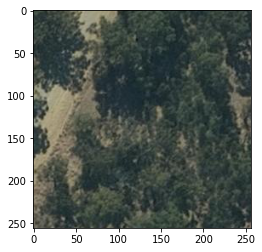

NameError: name 'pred_test_p' is not defined

In [47]:
import matplotlib.pyplot as plt
plt.imshow(scale_up_color_val(X_pred[x]))
plt.show()

plt.imshow(scale_up_color_val(np.reshape(pred_test_p,(256, 256, 1))))
plt.show()

In [ ]:
threshold = 0.5 # np.average(pred_test_p)
pred_test = (pred_test_p > threshold)

plt.imshow(scale_up_color_val(X_pred[x]))
plt.show()

plt.imshow(scale_up_color_val(np.reshape(pred_test_p,(256, 256, 1))))
plt.show()

In [ ]:
pred_test_p = model.predict(X_pred)
np.save(f"{config.path_data}4_pred/{config.pred_imgs[0][:-4]}.npy", pred_test_p)

: 

In [ ]:
def pred_img(filename):
    X_pred = np.load(f"{config.path_patches}pred_patches_{filename[:-4]}.npy")
    print(X_pred.shape)
    pred_sat = model.predict(X_pred) # confidence for class 0?
    show_pred(X_pred, pred_sat, 4)

: 

In [ ]:
for filename in config.pred_imgs:
    pred_img(filename)

: 

In [150]:
X_pred.shape

(1089, 256, 256, 3)

In [153]:
X_pred.shape[0], config.overlap, config.size

(1089, 32, 256)

In [156]:
from osgeo import gdal
dataset = gdal.Open(config.path_satellite + filename)
size = (dataset.RasterXSize, dataset.RasterYSize)
print(size)
del dataset

(108224, 107798)


In [200]:
num_of_img_in_row = 429
reconstructed_shape = (img_size_by_patches(n=num_of_img_in_row), img_size_by_patches(n=2), 3)
print(reconstructed_shape)

(96128, 480, 3)


In [237]:
start_copy = int(config.overlap/2)
endof_copy = int(config.size - config.overlap/2)
# X_pred[10][start_copy:endof_copy, start_copy:endof_copy].shape
X_pred[10][start_copy:endof_copy, start_copy:endof_copy].shape

(224, 224, 3)

In [317]:
def get_window(patch_num_row, patch_num_col):
    window_extend = config.size - config.overlap
    start_row = int(patch_num_row * (config.size - config.overlap) + config.overlap / 2)
    endof_row = int(start_row + window_extend)
    start_col = int(patch_num_col * (config.size - config.overlap) + config.overlap / 2)
    endof_col = int(start_col + window_extend)
    
    window = (start_row, endof_row, start_col, endof_col)
    return window

def reconstruct_img(patches, out_shape):
    reconstructed_img = np.zeros(out_shape) # TODO: Rand wird 16 px kleiner wegen overlap
    # patch origin window extend
    start_copy = int(config.overlap/2)
    endof_copy = int(config.size - config.overlap/2)

    num_of_img_in_row = 429 # TODO: should be dynamic. calc from out_shape
    for idx, patch in enumerate(patches, start=0):
        # reconstructed_img destination window extend
        patch_num_row, patch_num_col = idx // num_of_img_in_row, idx % num_of_img_in_row
        print("patch row, column:", patch_num_row, patch_num_col)
        (start_row, endof_row, start_col, endof_col) = get_window(patch_num_row, patch_num_col)
        if endof_col > out_shape[1]: 
            print("col end:",endof_col)
            patch_num_row += 1
            patch_num_col = 0
            continue
        if endof_row > out_shape[0]: 
            print("row end:",endof_row)
            break
        print("destination extnd:", start_row, endof_row, start_col, endof_col)
        print("destination shape:", reconstructed_img[start_row:endof_row, start_col:endof_col].shape)
        reconstructed_img[start_row:endof_row, start_col:endof_col] = patch[start_copy:endof_copy, start_copy:endof_copy]
        
    plt.imshow(reconstructed_img)
    plt.show()

In [311]:
X_pred.shape

(1089, 256, 256, 3)

patch row, column: 0 0
destination extnd: 16 240 16 240
destination shape: (224, 224, 3)
patch row, column: 0 1
destination extnd: 16 240 240 464
destination shape: (224, 224, 3)
patch row, column: 0 2
col end: 688
patch row, column: 0 3
col end: 912
patch row, column: 0 4
col end: 1136
patch row, column: 0 5
col end: 1360
patch row, column: 0 6
col end: 1584
patch row, column: 0 7
col end: 1808
patch row, column: 0 8
col end: 2032
patch row, column: 0 9
col end: 2256
patch row, column: 0 10
col end: 2480
patch row, column: 0 11
col end: 2704
patch row, column: 0 12
col end: 2928
patch row, column: 0 13
col end: 3152
patch row, column: 0 14
col end: 3376
patch row, column: 0 15
col end: 3600
patch row, column: 0 16
col end: 3824
patch row, column: 0 17
col end: 4048
patch row, column: 0 18
col end: 4272
patch row, column: 0 19
col end: 4496
patch row, column: 0 20
col end: 4720
patch row, column: 0 21
col end: 4944
patch row, column: 0 22
col end: 5168
patch row, column: 0 23
col end: 

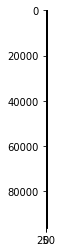

In [318]:
out_shape = (img_size_by_patches(n=429), img_size_by_patches(n=2), X_pred.shape[3])
reconstruct_img(X_pred, out_shape)

(480, 480, 3)


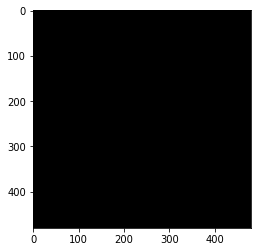

TypeError: Invalid shape (0, 256, 256, 3) for image data

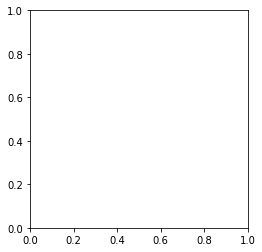

In [324]:
print(reconstructed_img[4000:4480].shape)
plt.imshow(reconstructed_img[4000:4480])
plt.show()
# satellite = rasterio read col/row
# plt.imshow(satellite[4000:4480])
# plt.show()

In [217]:
from patchify import unpatchify
# merge imgs
reconstructed_image = unpatchify(X_pred, reconstructed_shape) #patches, shape

AssertionError: The patches dimension is not equal to the original image size

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
# predict the target on test data 
pred_test_p = model.predict(X_test) # confidence for class 0

: 

In [ ]:
show(X_test[33], pred_test_p[33])

: 

In [ ]:
idx = 33
plt.imshow(scale_up_color_val(X_test[idx]))
plt.show()
plt.imshow(scale_up_color_val(pred_test_p[idx]))
plt.show()

: 

In [ ]:
for idx in range(900,1000,20):
    plt.imshow(scale_up_color_val(X_pred[idx]))
    plt.show()
    plt.imshow(scale_up_color_val(pred_sat[idx]))
    plt.show()

: 

In [ ]:
def pred_img(filename):
    X_pred = np.load(f"{config.path_patches}pred_patches_{filename[:-4]}.npy")
    print(X_pred.shape)
    pred_sat = model.predict(X_pred) # confidence for class 0?
    show_pred(X_pred, pred_sat, 4)

: 

In [ ]:
pred_sat.shape

: 

In [ ]:
print(np.min(pred_sat), np.max(pred_sat))

: 

: 